# **Preprocess Data and Create Labels and Features**

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [92]:
DATA_PATH = os.path.join('My_Datasets')

actions = np.array(["maaf", "tolong", "nama", "siapa", "rumah", "standby", "delete", "translate", "kamu"])

no_sequences = 30

sequence_length = 30

In [93]:

label_map = {label:num for num, label in enumerate(actions)}
label_map

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(270, 30, 108)

In [94]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(189, 30, 108)
(81, 30, 108)
(189, 9)
(81, 9)


# **Build and Train LSTM Neural Network**

In [95]:
checkpoint = ModelCheckpoint('test.h5', monitor='categorical_accuracy', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False,save_freq='epoch')

In [96]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=128, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))

# model.summary()

model = Sequential()

model.add(TimeDistributed(Dense(units=128, activation='tanh'), input_shape=(30, 108)))
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=False, activation='tanh')))
model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(32, return_sequences=False, activation='tanh')))
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 bidirectional_11 (Bidirect  (None, 30, 256)           263168    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 30, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                      

In [97]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(128, return_sequences=False, activation='tanh', input_shape=(30,108)))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [98]:
# COMPLEX MODEL -> EXPERIMENTAL
# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [99]:
# COMPLEX MODEL 2

# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

Epoch 1/15


5/6 [========================>.....] - ETA: 0s - loss: 2.0969 - categorical_accuracy: 0.2062
Epoch 1: categorical_accuracy improved from -inf to 0.23810, saving model to test.h5
6/6 [==============================] - 7s 252ms/step - loss: 2.0422 - categorical_accuracy: 0.2381 - val_loss: 1.7065 - val_categorical_accuracy: 0.4568
Epoch 2/15
3/6 [==============>...............] - ETA: 0s - loss: 1.6929 - categorical_accuracy: 0.4688

c:\Users\krisn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/6 [========================>.....] - ETA: 0s - loss: 1.6430 - categorical_accuracy: 0.4563
Epoch 2: categorical_accuracy improved from 0.23810 to 0.48677, saving model to test.h5
6/6 [==============================] - 0s 56ms/step - loss: 1.6096 - categorical_accuracy: 0.4868 - val_loss: 1.2980 - val_categorical_accuracy: 0.5556
Epoch 3/15
5/6 [========================>.....] - ETA: 0s - loss: 1.3073 - categorical_accuracy: 0.6062
Epoch 3: categorical_accuracy improved from 0.48677 to 0.60847, saving model to test.h5
6/6 [==============================] - 0s 56ms/step - loss: 1.2939 - categorical_accuracy: 0.6085 - val_loss: 0.9924 - val_categorical_accuracy: 0.7284
Epoch 4/15
5/6 [========================>.....] - ETA: 0s - loss: 0.9772 - categorical_accuracy: 0.7250
Epoch 4: categorical_accuracy improved from 0.60847 to 0.71429, saving model to test.h5
6/6 [==============================] - 0s 56ms/step - loss: 0.9600 - categorical_accuracy: 0.7143 - val_loss: 0.7706 - val_categori

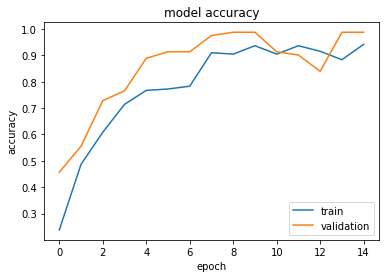

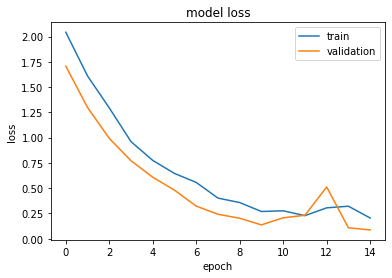

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 bidirectional_11 (Bidirect  (None, 30, 256)           263168    
 ional)                                                          
                                                                 
 dropout_16 (Dropout)        (None, 30, 256)           0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                      

In [100]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=15, callbacks=[checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
    
model.summary()

In [101]:
# plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**

In [102]:
number_of_classes = len(actions)
current_date = '28032024' # changes manually
version = 1

model_filename ="model/model_" +  str(number_of_classes) + '_' + 'lstm' + '_' + current_date + '_' + str(version) + ".h5"

print(model_filename)

model.save(model_filename)
model.load_weights(model_filename)

model/model_9_lstm_28032024_1.h5


In [103]:
model.load_weights(model_filename)

# **Evaluation using Confusion Matrix and Accuracy**

In [104]:
yhat = model.predict(X_test)

3/3 [==============================] - 1s 13ms/step


In [105]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

nama
nama


In [106]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [107]:
from sklearn.metrics import classification_report

# Assuming ytrue and yhat are the true and predicted labels, respectively
report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        maaf       1.00      1.00      1.00        10
      tolong       1.00      1.00      1.00         8
        nama       1.00      1.00      1.00        10
       siapa       1.00      0.92      0.96        12
       rumah       1.00      1.00      1.00         8
     standby       1.00      1.00      1.00         5
      delete       1.00      1.00      1.00        13
   translate       1.00      1.00      1.00         8
        kamu       0.88      1.00      0.93         7

    accuracy                           0.99        81
   macro avg       0.99      0.99      0.99        81
weighted avg       0.99      0.99      0.99        81



In [108]:
# mcm = multilabel_confusion_matrix(ytrue, yhat)
# print(mcm)

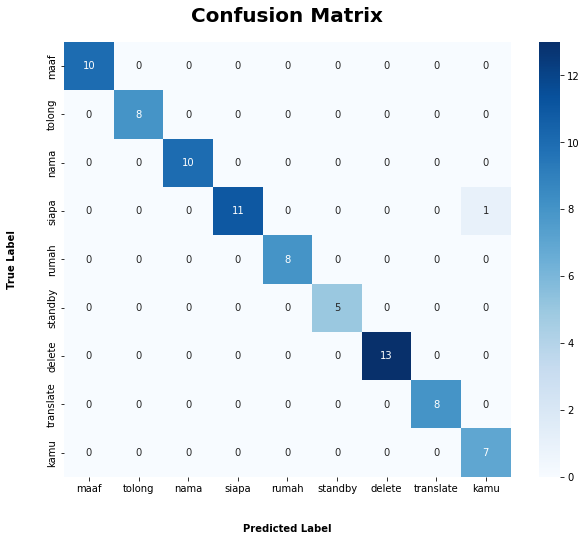

In [109]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [110]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming ytrue and yhat are the true and predicted labels, respectively
metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

# Print metrics for each class
for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

# For accuracy per class, you would need to calculate it manually:
accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i])) for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: maaf
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: tolong
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: nama
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: siapa
Precision: 1.0
Recall: 0.9166666666666666
F1 Score: 0.9565217391304348

Class: rumah
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: standby
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: delete
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: translate
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: kamu
Precision: 0.875
Recall: 1.0
F1 Score: 0.9333333333333333

Class: maaf
Accuracy: 1.0

Class: tolong
Accuracy: 1.0

Class: nama
Accuracy: 1.0

Class: siapa
Accuracy: 1.0

Class: rumah
Accuracy: 1.0

Class: standby
Accuracy: 1.0

Class: delete
Accuracy: 1.0

Class: translate
Accuracy: 1.0

Class: kamu
Accuracy: 0.875

